In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import itertools

from ms_entropy.file_io.msp_file import read_one_spectrum
import numba as nb
import pyteomics.mgf
import sys
import importlib

sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns

importlib.reload(sys.modules["create_spectrum"])
importlib.reload(sys.modules["reformat_columns"])
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns

In [2]:
QUERY_DIR = "../../data/modified_cosine_queries/"
QUERY_PATH = (
    "s3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/"
)
DATA_DIR = "../../data/"

UNWEIGHTED_FILE = "no_weights/filtered_10_ppm"
WEIGHTED_FILES = [
    "our_weights/weighted_filtered_10_ppm",
    "Stein_weights_0.6_3/10_ppm_stein_weights_0.6_3",
    "Stein_weights_0.5_1/10_ppm_stein_weights_0.5_1",
    "Stein_weights_0.5_2/10_ppm_stein_weights_0.5_2",
    # 'Stein_weights_0.6_2/10_ppm_stein_weights_0.6_2',
    "Stein_weights_0.53_1.3/10_ppm_stein_weights_0.53_1.3",
]

NAME_DICT = {
    "our_weights/weighted_filtered_10_ppm": "Our weights",
    "Stein_weights_0.6_3/10_ppm_stein_weights_0.6_3": "Stein and Scott",
    "Stein_weights_0.5_1/10_ppm_stein_weights_0.5_1": "Sokolow",
    "Stein_weights_0.5_2/10_ppm_stein_weights_0.5_2": "Horai",
    #  'Stein_weights_0.6_2/10_ppm_stein_weights_0.6_2': 'NIST',
    "Stein_weights_0.53_1.3/10_ppm_stein_weights_0.53_1.3": "Kim",
}
WEIGHTED_NAMES = [NAME_DICT[file] for file in WEIGHTED_FILES]

# Get queries

In [4]:
# Get the NIST23 queries
# queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
# weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}_with_stats.csv', index_col=0)
queries = pd.read_csv(f"{QUERY_PATH}{UNWEIGHTED_FILE}_with_stats.csv", index_col=0)
shared_queries = set(queries.wout_identifier)

# Get the NIST23 weighted queries
weighted_queries = {}
for name in tqdm(WEIGHTED_FILES):
    try:
        weighted_queries[NAME_DICT[name]] = pd.read_csv(
            f"{QUERY_PATH}{name}_with_stats.csv", index_col=0
        )
    except:
        weighted_queries[NAME_DICT[name]] = pd.read_csv(
            f"{QUERY_PATH}{name}_with_stats.csv", index_col=0
        )
        shared_queries = shared_queries.intersection(
            set(weighted_queries[NAME_DICT[name]].wout_identifier)
        )

# Filter the queries to only include queries in both the weighted and unweighted queries
queries = queries[queries["wout_identifier"].isin(shared_queries)]
for name in WEIGHTED_NAMES:
    weighted_queries[name] = weighted_queries[name][
        weighted_queries[name]["wout_identifier"].isin(shared_queries)
    ]

100%|██████████| 5/5 [00:46<00:00,  9.30s/it]


In [5]:
# Reformat columns in the query dataframe
queries = reformat_columns(
    ["library_spectra_matches", "exact_matches", "nist_inchis", "smiles", "tanimoto"],
    query_type="modified_cosine",
    query_df=queries,
)
queries["tanimoto"] = queries["tanimoto"].apply(lambda x: x.astype(float))

# Reformat columns in the weightd query dataframe
for name in WEIGHTED_NAMES:
    weighted_queries[name] = reformat_columns(
        [
            "library_spectra_matches",
            "exact_matches",
            "nist_inchis",
            "smiles",
            "tanimoto",
        ],
        query_type="modified_cosine",
        query_df=weighted_queries[name],
    )

100%|██████████| 25437/25437 [00:00<00:00, 65489.22it/s]


# Create figure 3

In [6]:
# Create dataframe for number of matches
num_matches = pd.DataFrame(
    columns=[
        "num_queries_without_matches",
        "average_num_matches",
        "max_num_matches",
        "average_num_exact_matches",
        "num_queries_without_exact_matches",
    ]
)
num_matches.loc["col_names"] = [
    "Any matches",
    "Any matches",
    "Any matches",
    "Exact matches",
    "Exact matches",
]

# Get number of matches per query
num_matches_list = queries.library_spectra_matches.apply(lambda x: len(x))
num_exact_matches = queries.exact_matches.apply(lambda x: len(x))
num_matches.loc["Unweighted"] = [
    len(num_matches_list[num_matches_list == 0]),
    num_matches_list.mean(),
    num_matches_list.max(),
    num_exact_matches.mean(),
    len(num_exact_matches[num_exact_matches == 0]),
]

# Get number of matches per query for each weighting method
for name in WEIGHTED_NAMES:
    num_matches_list = weighted_queries[name].library_spectra_matches.apply(
        lambda x: len(x)
    )
    num_exact_matches = weighted_queries[name].exact_matches.apply(lambda x: len(x))
    num_matches.loc[name.split("/")[-1]] = [
        len(num_matches_list[num_matches_list == 0]),
        num_matches_list.mean(),
        num_matches_list.max(),
        num_exact_matches.mean(),
        len(num_exact_matches[num_exact_matches == 0]),
    ]

In [7]:
# Create data frame
column_names = [x.split("/")[-1] for x in WEIGHTED_NAMES] + ["Unweighted"]
average_tanimoto_top_n = pd.DataFrame(
    columns=column_names, index=["top_1", "top_5", "top_10"]
)
sd_tanimoto_top_n = pd.DataFrame(
    columns=column_names, index=["top_1", "top_5", "top_10"]
)
n_vals = [1, 5, 10]

# Calculate average tanimoto score for top n results
for n in n_vals:
    average_tanimoto_top_n.loc[f"top_{n}", "Unweighted"] = np.mean(
        list(
            itertools.chain.from_iterable(
                [x[:n] for x in queries["tanimoto"] if len(x) > 0]
            )
        )
    )
    sd_tanimoto_top_n.loc[f"top_{n}", "Unweighted"] = np.std(
        list(
            itertools.chain.from_iterable(
                [x[:n] for x in queries["tanimoto"] if len(x) > 0]
            )
        )
    )
    for name in WEIGHTED_NAMES:
        average_tanimoto_top_n.loc[f"top_{n}", name] = np.mean(
            list(
                itertools.chain.from_iterable(
                    [x[:n] for x in weighted_queries[name]["tanimoto"] if len(x) > 0]
                )
            )
        )
        sd_tanimoto_top_n.loc[f"top_{n}", name] = np.std(
            list(
                itertools.chain.from_iterable(
                    [x[:n] for x in weighted_queries[name]["tanimoto"] if len(x) > 0]
                )
            )
        )

In [8]:
# Create data frame
column_names = WEIGHTED_NAMES + ["Unweighted"]
exact_matches_precision = pd.DataFrame(
    columns=column_names, index=["top_1", "top_5", "top_10"]
)
exact_matches_precision_sd = pd.DataFrame(
    columns=column_names, index=["top_1", "top_5", "top_10"]
)
n_vals = [1, 5, 10]

# Get precision of top n matches
for n in n_vals:
    exact_matches_precision.loc[f"top_{n}", "Unweighted"] = (
        queries["exact_matches"].apply(lambda x: len(x[x < n]) / n).mean()
    )
    exact_matches_precision_sd.loc[f"top_{n}", "Unweighted"] = (
        queries["exact_matches"].apply(lambda x: len(x[x < n]) / n).std()
    )
    for name in WEIGHTED_NAMES:
        exact_matches_precision.loc[f"top_{n}", name] = (
            weighted_queries[name]["exact_matches"]
            .apply(lambda x: len(x[x < n]) / n)
            .mean()
        )
        exact_matches_precision_sd.loc[f"top_{n}", name] = (
            weighted_queries[name]["exact_matches"]
            .apply(lambda x: len(x[x < n]) / n)
            .std()
        )

In [9]:
# Get number of matches above a threshold
thresholds = [0.5, 0.7, 0.9]
threshold_df = pd.DataFrame(columns=thresholds)
threshold_sd_df = pd.DataFrame(columns=thresholds)
for threshold in thresholds:
    threshold_df.loc["Unweighted", threshold] = queries.library_spectra_matches.apply(
        lambda x: len([y for y in x if y[1] > threshold])
    ).mean()
    threshold_sd_df.loc[
        "Unweighted", threshold
    ] = queries.library_spectra_matches.apply(
        lambda x: len([y for y in x if y[1] > threshold])
    ).std()
    for name in WEIGHTED_NAMES:
        threshold_df.loc[name, threshold] = (
            weighted_queries[name]
            .library_spectra_matches.apply(
                lambda x: len([y for y in x if y[1] > threshold])
            )
            .mean()
        )
        threshold_sd_df.loc[name, threshold] = (
            weighted_queries[name]
            .library_spectra_matches.apply(
                lambda x: len([y for y in x if y[1] > threshold])
            )
            .std()
        )

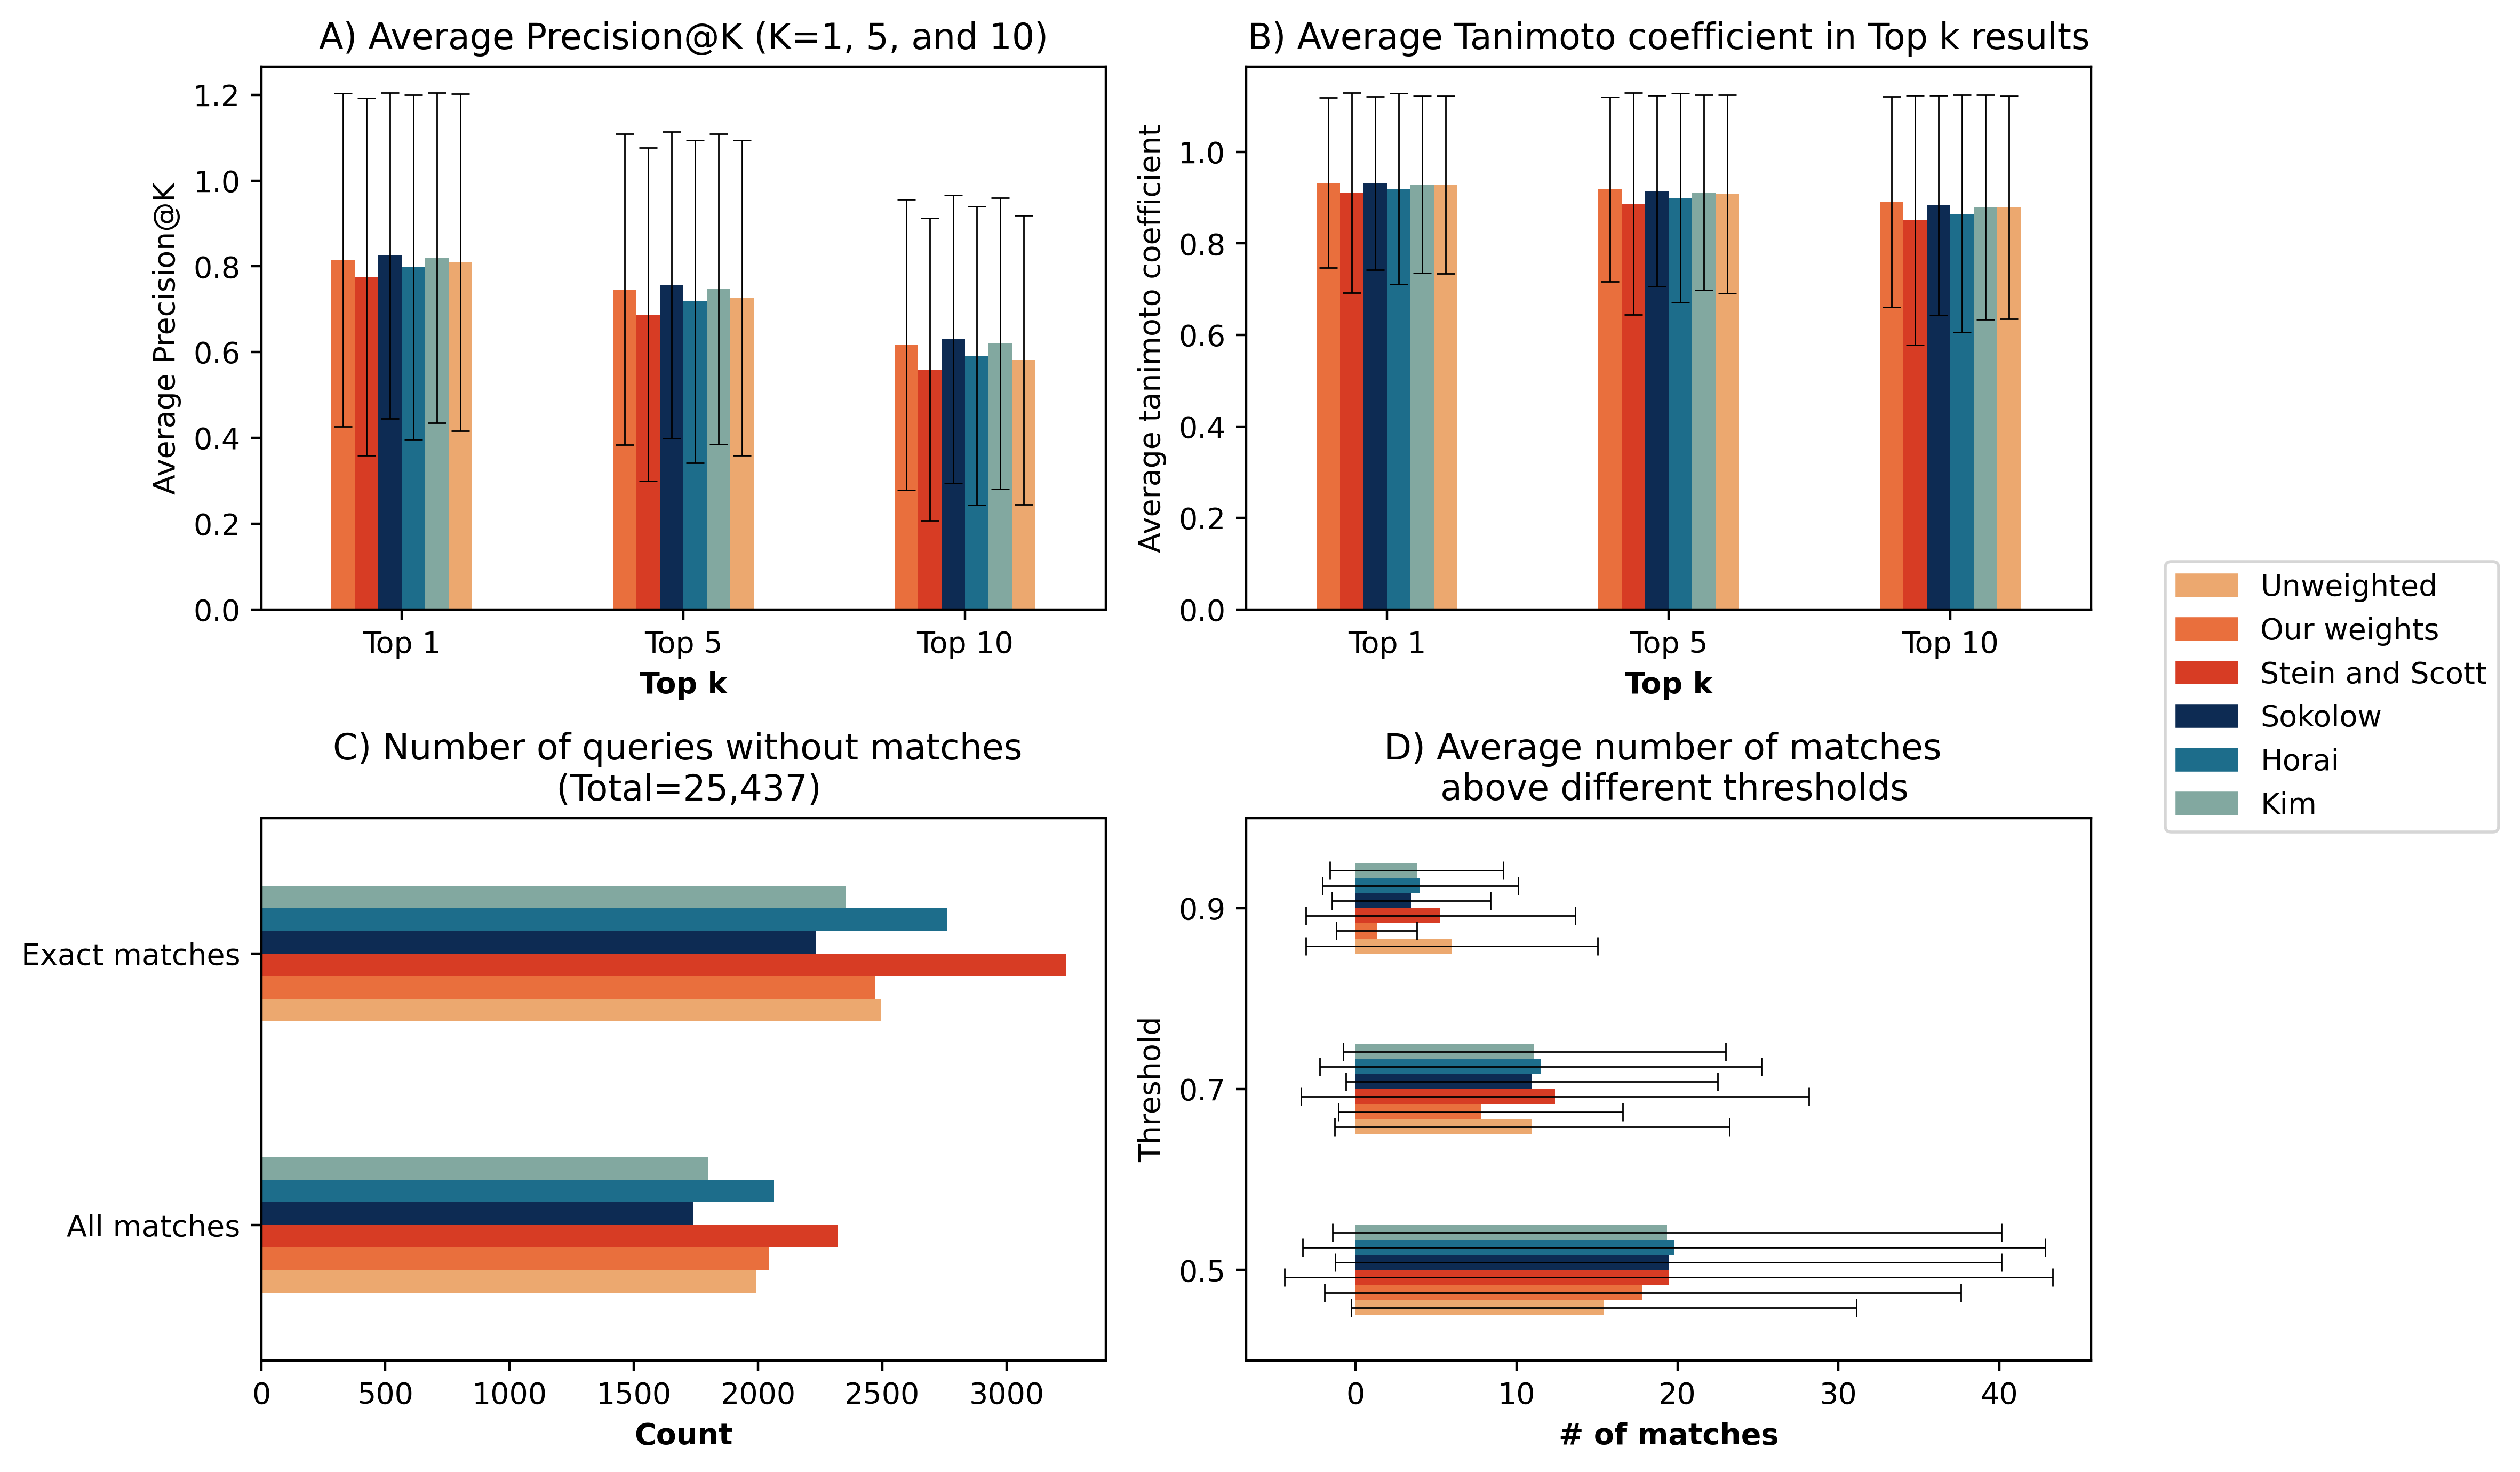

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), dpi=400)
color_dict = {
    "Unweighted": "#eca86f",
    "Our weights": "#e96f3d",
    "Stein and Scott": "#d73c24",
    "Sokolow": "#0d2b53",
    "Horai": "#1d6d8b",
    "Kim": "#82a8a0",
}

# color_dict = {
#     "Unweighted": (0.035, 0.725, 0.886),  # Light Blue-Green
#     "Our weights": (0.090, 0.580, 0.655),  # Medium Blue-Green
#     "Stein and Scott": (0.129, 0.474, 0.537),  # Dark Blue-Green
#     "Sokolow": (0.337, 0.725, 0.474),  # Light Green-Blue
#     "Horai": (0.212, 0.565, 0.357),  # Medium Green-Blue
#     "Kim": (0.090, 0.435, 0.278),  # Dark Green-Blue
# }


# Define handles
handles = []
for name in color_dict.keys():
    handles.append(mpatches.Patch(color=color_dict[name], label=name))

# Create bar plot
container = exact_matches_precision.plot.bar(
    rot=0,
    ax=axes[0, 0],
    color=color_dict,
    legend=False,
    yerr=exact_matches_precision_sd,
    capsize=4,
    ecolor="black",
    error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
)
axes[0, 0].set_title("A) Average Precision@K (K=1, 5, and 10)")
axes[0, 0].set_ylabel("Average Precision@K")
axes[0, 0].set_xlabel("Top k", weight="bold")

# Set ticks
axes[0, 0].set_xticklabels(["Top 1", "Top 5", "Top 10"])

num_matches[
    ["num_queries_without_matches", "num_queries_without_exact_matches"]
].T.plot.barh(color=color_dict, ax=axes[1, 0], legend=False)
axes[1, 0].set_title("C) Number of queries without matches \n (Total=25,437)")
axes[1, 0].set_yticklabels(["All matches", "Exact matches"])
axes[1, 0].set_xlabel("Count", weight="bold")

# Create bar plot
average_tanimoto_top_n.plot.bar(
    rot=0,
    color=color_dict,
    ax=axes[0, 1],
    legend=False,
    yerr=sd_tanimoto_top_n,
    capsize=4,
    ecolor="black",
    error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
)
axes[0, 1].set_title("B) Average Tanimoto coefficient in Top k results")
axes[0, 1].set_ylabel("Average tanimoto coefficient")
axes[0, 1].set_xlabel("Top k", weight="bold")
axes[0, 1].set_xticklabels(["Top 1", "Top 5", "Top 10"])

threshold_df.T.plot.barh(
    color=color_dict,
    ax=axes[1, 1],
    legend=False,
    xerr=threshold_sd_df.T,
    capsize=4,
    ecolor="black",
    error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
)
axes[1, 1].set_title("D) Average number of matches \n above different thresholds")
axes[1, 1].set_ylabel("Threshold")
axes[1, 1].set_xlabel("# of matches", weight="bold")

plt.tight_layout()
plt.legend(handles=[x for x in handles], bbox_to_anchor=(1.5, 1.5))
plt.savefig("../../data/figure_3.png", dpi=400)
plt.show()

In [10]:
threshold_df

,0.5,0.7,0.9
Unweighted,15.424814,10.959311,5.967488
Our weights,17.831859,7.760664,1.293981
Stein and Scott,19.456264,12.381963,5.257145
Sokolow,19.436923,10.950702,3.4554
Horai,19.779062,11.494673,4.012501
Kim,19.351614,11.100719,3.782207


# Look at ranks of exact matches

### Look at ranks of exact matches

In [11]:
# Get all ranks of exact matches
all_ranks = list(itertools.chain(*list(queries["exact_matches"])))
all_ranks_weighted = {}
for name in WEIGHTED_NAMES:
    all_ranks_weighted[name] = list(
        itertools.chain(*list(weighted_queries[name]["exact_matches"]))
    )

# Get highest rank of exact matches for each query
all_rank_1 = [x[0] for x in queries["exact_matches"] if len(x) > 0]
all_rank_1_weighted = {}
for name in WEIGHTED_NAMES:
    all_rank_1_weighted[name] = [
        x[0] for x in weighted_queries[name]["exact_matches"] if len(x) > 0
    ]

#### Look at the percent of queries with an exact match in the top n matches

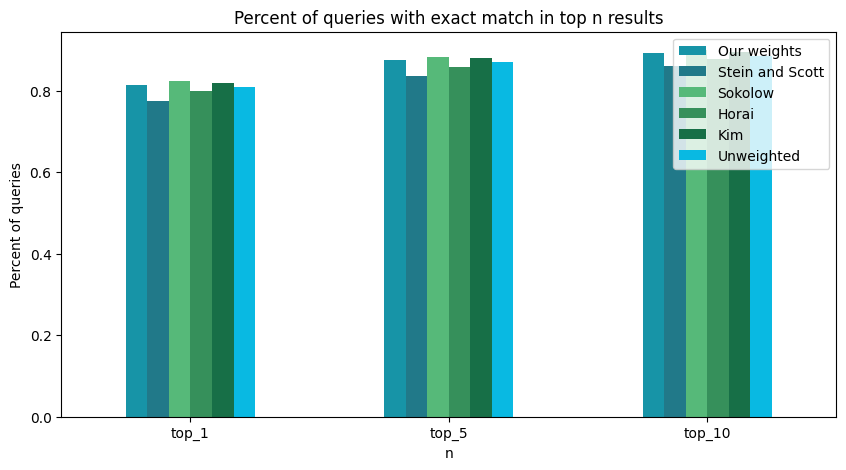

In [16]:
# Create data frame
column_names = WEIGHTED_NAMES + ["Unweighted"]
exact_matches_top_n = pd.DataFrame(
    columns=column_names, index=["top_1", "top_5", "top_10"]
)
n_vals = [1, 5, 10]

# Get percent of queries with exact match in top 5
for n in n_vals:
    exact_matches_top_n.loc[f"top_{n}", "Unweighted"] = (
        queries.loc[
            queries["exact_matches"].apply(lambda x: min(x) if len(x) > 0 else np.nan)
            < n
        ].shape[0]
        / queries.shape[0]
    )
    for name in WEIGHTED_NAMES:
        exact_matches_top_n.loc[f"top_{n}", name] = (
            weighted_queries[name]
            .loc[
                weighted_queries[name]["exact_matches"].apply(
                    lambda x: min(x) if len(x) > 0 else np.nan
                )
                < n
            ]
            .shape[0]
            / weighted_queries[name].shape[0]
        )

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10, 5), rot=0, color=color_dict)
plt.title("Percent of queries with exact match in top n results")
plt.ylabel("Percent of queries")
plt.xlabel("n")
plt.show()

# Look at AUC scores

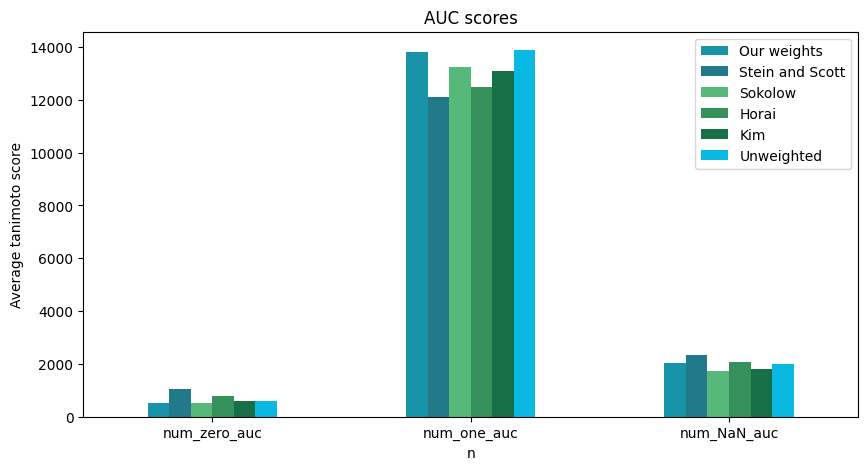

In [18]:
auc_scores = pd.DataFrame(
    index=["avg_auc", "num_zero_auc", "num_one_auc", "num_NaN_auc"],
    columns=column_names,
)

#
auc_scores["Unweighted"] = [
    queries.auc.mean(),
    queries.auc.loc[queries.auc == 0].count(),
    queries.auc.loc[queries.auc == 1].count(),
    queries.auc.isna().sum(),
]
for name in WEIGHTED_NAMES:
    auc_scores[name] = [
        weighted_queries[name].auc.mean(),
        weighted_queries[name].auc.loc[weighted_queries[name].auc == 0].count(),
        weighted_queries[name].auc.loc[weighted_queries[name].auc == 1].count(),
        weighted_queries[name].auc.isna().sum(),
    ]

# Create bar plot
auc_scores.loc[["num_zero_auc", "num_one_auc", "num_NaN_auc"]].plot.bar(
    figsize=(10, 5), rot=0, color=color_dict
)
plt.title("AUC scores")
plt.ylabel("Average tanimoto score")
plt.xlabel("n")
plt.show()

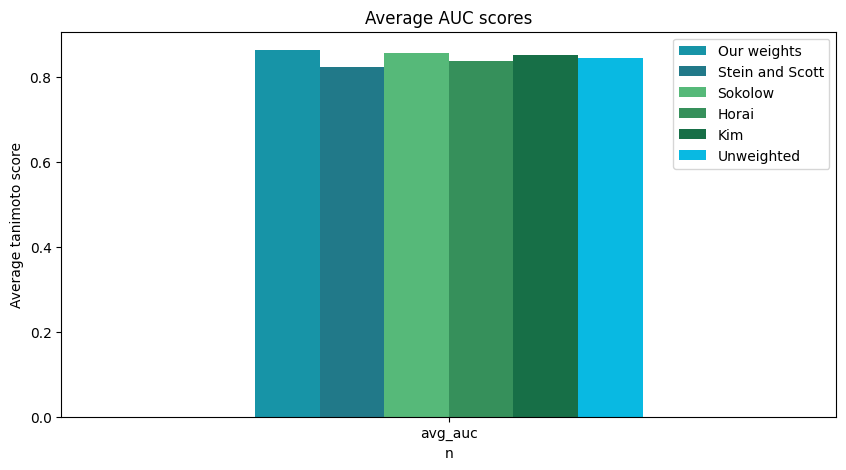

In [19]:
# Create bar plot
auc_scores.loc[["avg_auc"]].plot.bar(figsize=(10, 5), rot=0, color=color_dict)
plt.title("Average AUC scores")
plt.ylabel("Average tanimoto score")
plt.xlabel("n")
plt.show()